In [13]:
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split  
from sklearn.inspection import PartialDependenceDisplay  
import shap
from lime import lime_tabular
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestClassifier
import warnings

In [14]:
def load_data_and_split(file_path, target_column):
    """
    Load the dataset and split it into training and testing sets.
    
    Args:
        file_path (str): Path to the CSV dataset file.
        target_column (str): Name of the target column for churn.
    
    Returns:
        X_train, X_test, y_train, y_test: Split data.
    """
    # Load the dataset
    data = pd.read_csv(file_path)

    # Separate features and target variable
    X = data.drop(columns=[target_column])
    y = data[target_column]

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    return X_train, X_test, y_train, y_test

def plot_pdp(model, X_train, features):
    """
    Plot Partial Dependence for specified features using PartialDependenceDisplay,
    while suppressing warnings.
    
    Args:
        model: The trained model to explain.
        X_train: Training data (pandas DataFrame or numpy array).
        features: List of features or feature indices to plot.
    """
    # Suppress all warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        
        # Generate the Partial Dependence Plot
        display = PartialDependenceDisplay.from_estimator(model, X_train, features)
    
    # Show the plot
    plt.show()

def global_shap_analysis(model, X_train, X_test):
    """
    Perform global SHAP analysis using KernelExplainer with summarized background data.
    """
    K = 100  # Number of samples for summarization
    summarized_data = shap.kmeans(X_train.values, K)  # Summarize background data using k-means

    explainer = shap.KernelExplainer(model.predict_proba, summarized_data)
    shap_values = explainer.shap_values(X_test.values)
    
    shap.summary_plot(shap_values, X_test.values)
    plt.show()

def lime_explain(model, X_train, X_test, instance_idx):
    """
    Explain a single instance using LIME.
    """
    explainer = lime_tabular.LimeTabularExplainer(
        X_train.values,
        mode="classification",  # Change to "classification" if churn is binary classification
        feature_names=X_train.columns,
        class_names=['Not Churn', 'Churn']  # Adjust based on your target classes
    )
    
    exp = explainer.explain_instance(X_test.iloc[instance_idx].values, model.predict_proba)
    
    exp.show_in_notebook(show_table=True)

def local_shap_analysis(model, X, instance_idx):
    """
    Perform local SHAP analysis for a single instance.
    """
    K = 100  # Number of samples for summarization
    summarized_data = shap.kmeans(X.values, K)  # Summarize background data using k-means
    
    explainer = shap.KernelExplainer(model.predict_proba, summarized_data)
    
    shap_values = explainer.shap_values(X.iloc[instance_idx])
    
    shap.force_plot(explainer.expected_value[1], shap_values[1], X.iloc[instance_idx])
    plt.show()

def train_surrogate_tree(model, X):
    """
    Train a surrogate decision tree model.
    """
    y_pred = model.predict(X)
    
   # Train a surrogate decision tree model using predictions from the original model
    surrogate_tree = DecisionTreeRegressor(max_depth=3)
    surrogate_tree.fit(X, y_pred)
   
    return surrogate_tree

def plot_surrogate_tree(surrogate_tree, feature_names):
    """
    Plot the surrogate decision tree.
    """
    plt.figure(figsize=(20,10))
    plot_tree(surrogate_tree, feature_names=feature_names, filled=True, rounded=True)
    plt.show()

def loco_importance(model, X, y):
    """
    Calculate LOCO (Leave One Covariate Out) importance for each feature.
    
   Args:
       model: The trained model to evaluate.
       X: Features DataFrame.
       y: Target variable Series.

   Returns:
       importance: Dictionary with feature names as keys and importance scores as values.
   """
    baseline_score = model.score(X, y)
   
    importance = {}
   
    for col in X.columns:
        X_loco = X.copy()
        X_loco[col] = X_loco[col].mean()  # Replace with mean value of the feature
        loco_score = model.score(X_loco, y)
        importance[col] = baseline_score - loco_score
        
    return importance

# Main execution

# Load data and split (update filename and target column accordingly)




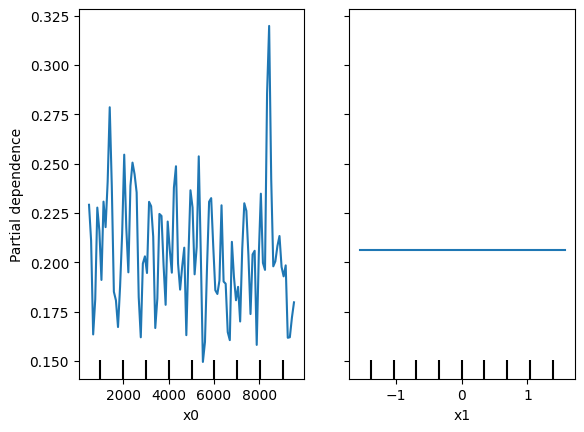

In [15]:
file_path = "../data/output_file.csv"  # Path to your dataset CSV file
target_column = "churn"          # Name of your target column

X_train, X_test, y_train, y_test = load_data_and_split(file_path, target_column)

# Train your model here (example with KNeighborsClassifier or any other model)
model_path = '../notebooks/KNeighbors_best_model.joblib'  # Path to your deployed model
model = joblib.load(model_path)

# 1. Partial Dependence Plot (adjust features based on your dataset)
features = [0, 1]  # Adjust these indices based on your features; you can also use feature names if preferred.
plot_pdp(model, X_train.values, features)

C:\Program Files\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


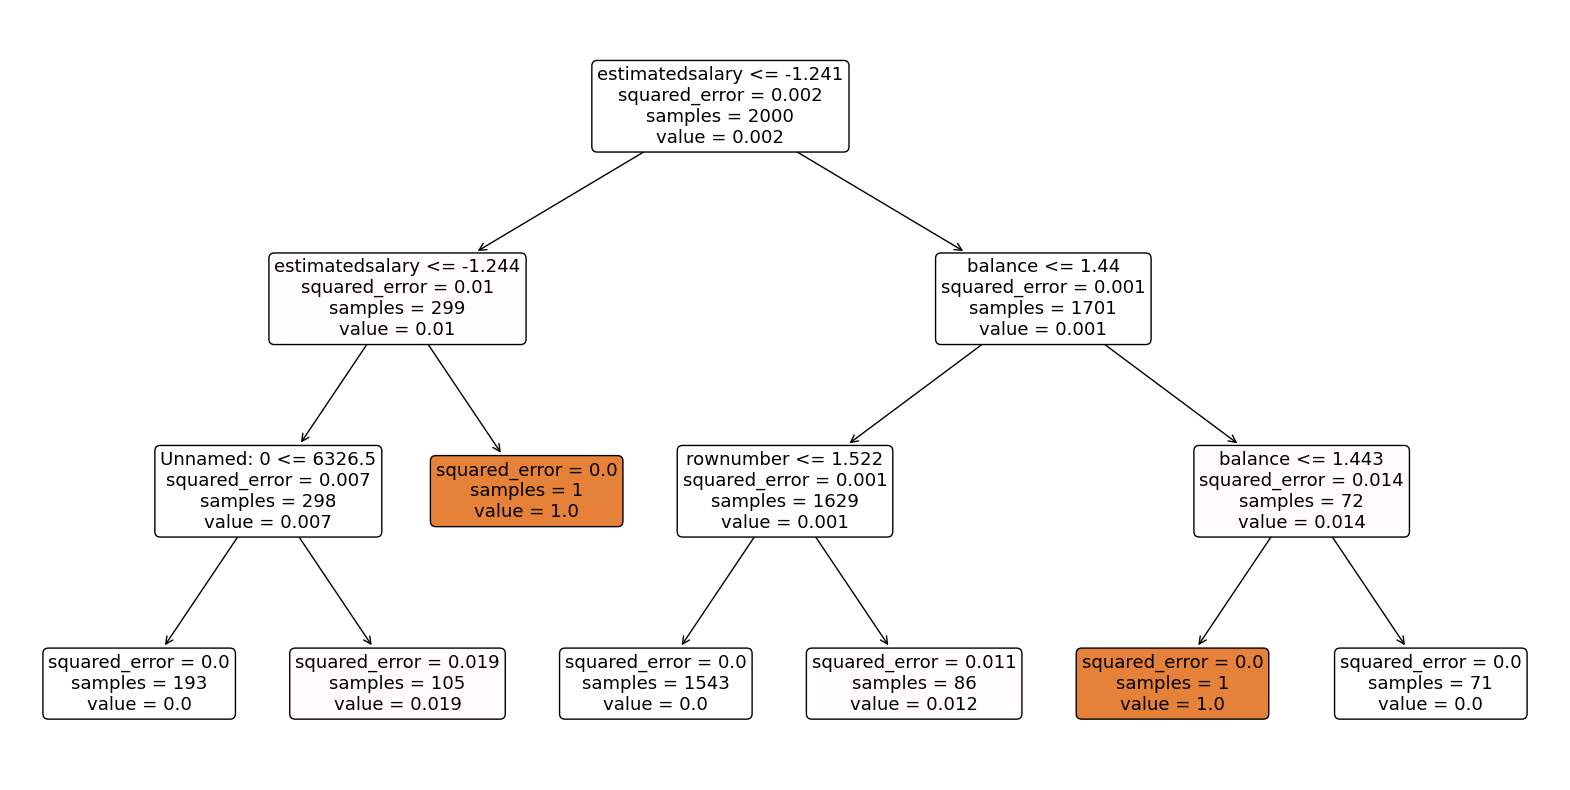

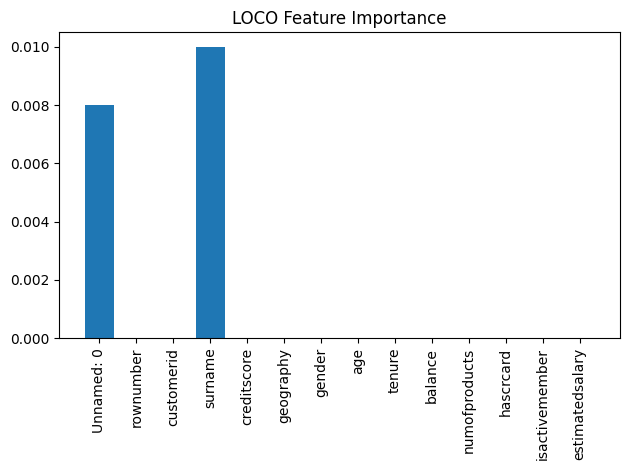

In [16]:
# 2. Global SHAP Analysis
lobal_shap_analysis(model, X_train, X_test)

# 3. LIME Explanation for the first instance (index 0)
lime_explain(model, X_train, X_test, instance_idx=0)

# 5. Surrogate Tree Model
surrogate_tree = train_surrogate_tree(model, X_test)
plot_surrogate_tree(surrogate_tree, X_test.columns)

# 6. LOCO Importance Calculation and Plotting
loco_importances = loco_importance(model, X_test, y_test)
plt.bar(loco_importances.keys(), loco_importances.values())
plt.xticks(rotation=90)
plt.title("LOCO Feature Importance")
plt.tight_layout()
plt.show()